In [2]:
import numba
from numba import cuda
import numpy as np
from numpy import math
import cmath
import time
import matplotlib.pyplot as plt
from scipy import signal

TPB = 16
pi = np.pi
@cuda.jit
def STCU(F_data,output,N,w,L_wavelet,widths):
    row,col = cuda.grid(2)
    N2 = len(widths)
    if row*2>0 and row*2<N2 and col*2<N and col*2>0:
        for x in range(2):
            for y in range(2):
                output[row*2+y,col*2+x] = 0
                for i in range(-L_wavelet,L_wavelet):
                    if row*2+y+i>0 and row*2+y+i<N2:
                        floc = numba.uint16(widths[row*2+y+i])
                        output[row*2+y,col*2+x] += (F_data[floc])* \
                        numba.complex128(cmath.exp(-2*w*pi**2*(i)**2/(row*2+y)**2)*cmath.exp(1j*2*pi*(i+L_wavelet)*(col*2+x)/N))
            



Elapsed=2.157231330871582


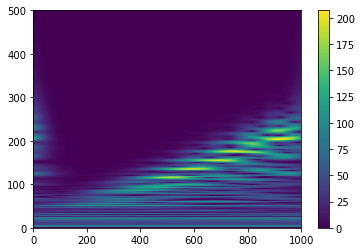

In [6]:
t = np.arange(0,1,0.001)
y = 4*np.sin(2*np.pi*10*t)+4*t
x = np.cos(2*np.pi*y*t)
widths = np.arange(0,500,1)
N = len(t)
N2 = len(widths)
#F_data = np.fft.fft(Highpass(train_00000e74ad[2],f=500))
F_data = np.fft.fft(x)
F_data = numba.complex128(F_data)
A = cuda.to_device(F_data)
output = cuda.device_array((N2,N),dtype=np.complex128,order='F')
threadsperblock = (TPB,TPB)
blockspergrid_x = int(math.ceil(N2/threadsperblock[0]/2))
blockspergrid_y = int(math.ceil(N/threadsperblock[1]/2))
blockpergrid = (blockspergrid_x,blockspergrid_y)
#print(blockpergrid)
start = time.time()
#st_result = ST(Highpass(train_00000e74ad[2],f=500))


st_result = STCU[blockpergrid,threadsperblock](A,output,N,80,150,widths)

result = output.copy_to_host()
end = time.time()
print("Elapsed=%s"%(end-start))
plt.pcolormesh(np.abs(result))
plt.colorbar()
plt.show()
#print(result)

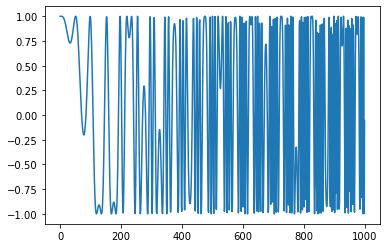

In [7]:
plt.plot(x)
plt.show()